In [1]:
import json
from pathlib import Path

import h5netcdf
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

In [3]:
# plotting settings
DATAROOT = Path("../data")
FIGROOT = Path("../fig")
FIGDPI = 600
FIGSUFFIX = ".pdf"

plt.style.use("seaborn-v0_8-colorblind")
plt.rcParams.update(
    {
        "savefig.pad_inches": 0.05 / 2.54,
        "grid.linewidth": 0.25,
        "axes.titlesize": 8,
        "axes.titlepad": 0.05,
        "axes.labelsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "legend.fontsize": 8,
    }
)

In [4]:
GEOEM_FILE = DATAROOT.joinpath("wrf_domain.nc")
with h5netcdf.File(GEOEM_FILE, "r") as f:
    lon = np.array(f.variables["lon"][:], dtype=np.float64)
    lat = np.array(f.variables["lat"][:], dtype=np.float64)
    hgt = np.array(f.variables["HGT"][:, :], dtype=np.float32)

In [5]:
WEIGHT_FILE = DATAROOT.joinpath("rivnet.parquet")
rivnet = pl.read_parquet(WEIGHT_FILE)
print(f"There are {rivnet.height} rivers in the dataset.")

There are 5800 rivers in the dataset.


In [6]:
gauge = pl.read_csv(DATAROOT.joinpath("gauge_q_loc.csv"))

In [8]:
coast = []
with open(DATAROOT.joinpath("coastline.geojsonl")) as f:
    for line in f:
        lines = json.loads(line)["geometry"]["coordinates"]
        for ll in lines:
            clat = []
            clon = []
            for lll in ll:
                clat.append(lll[1])
                clon.append(lll[0])
            coast.append((clat, clon))

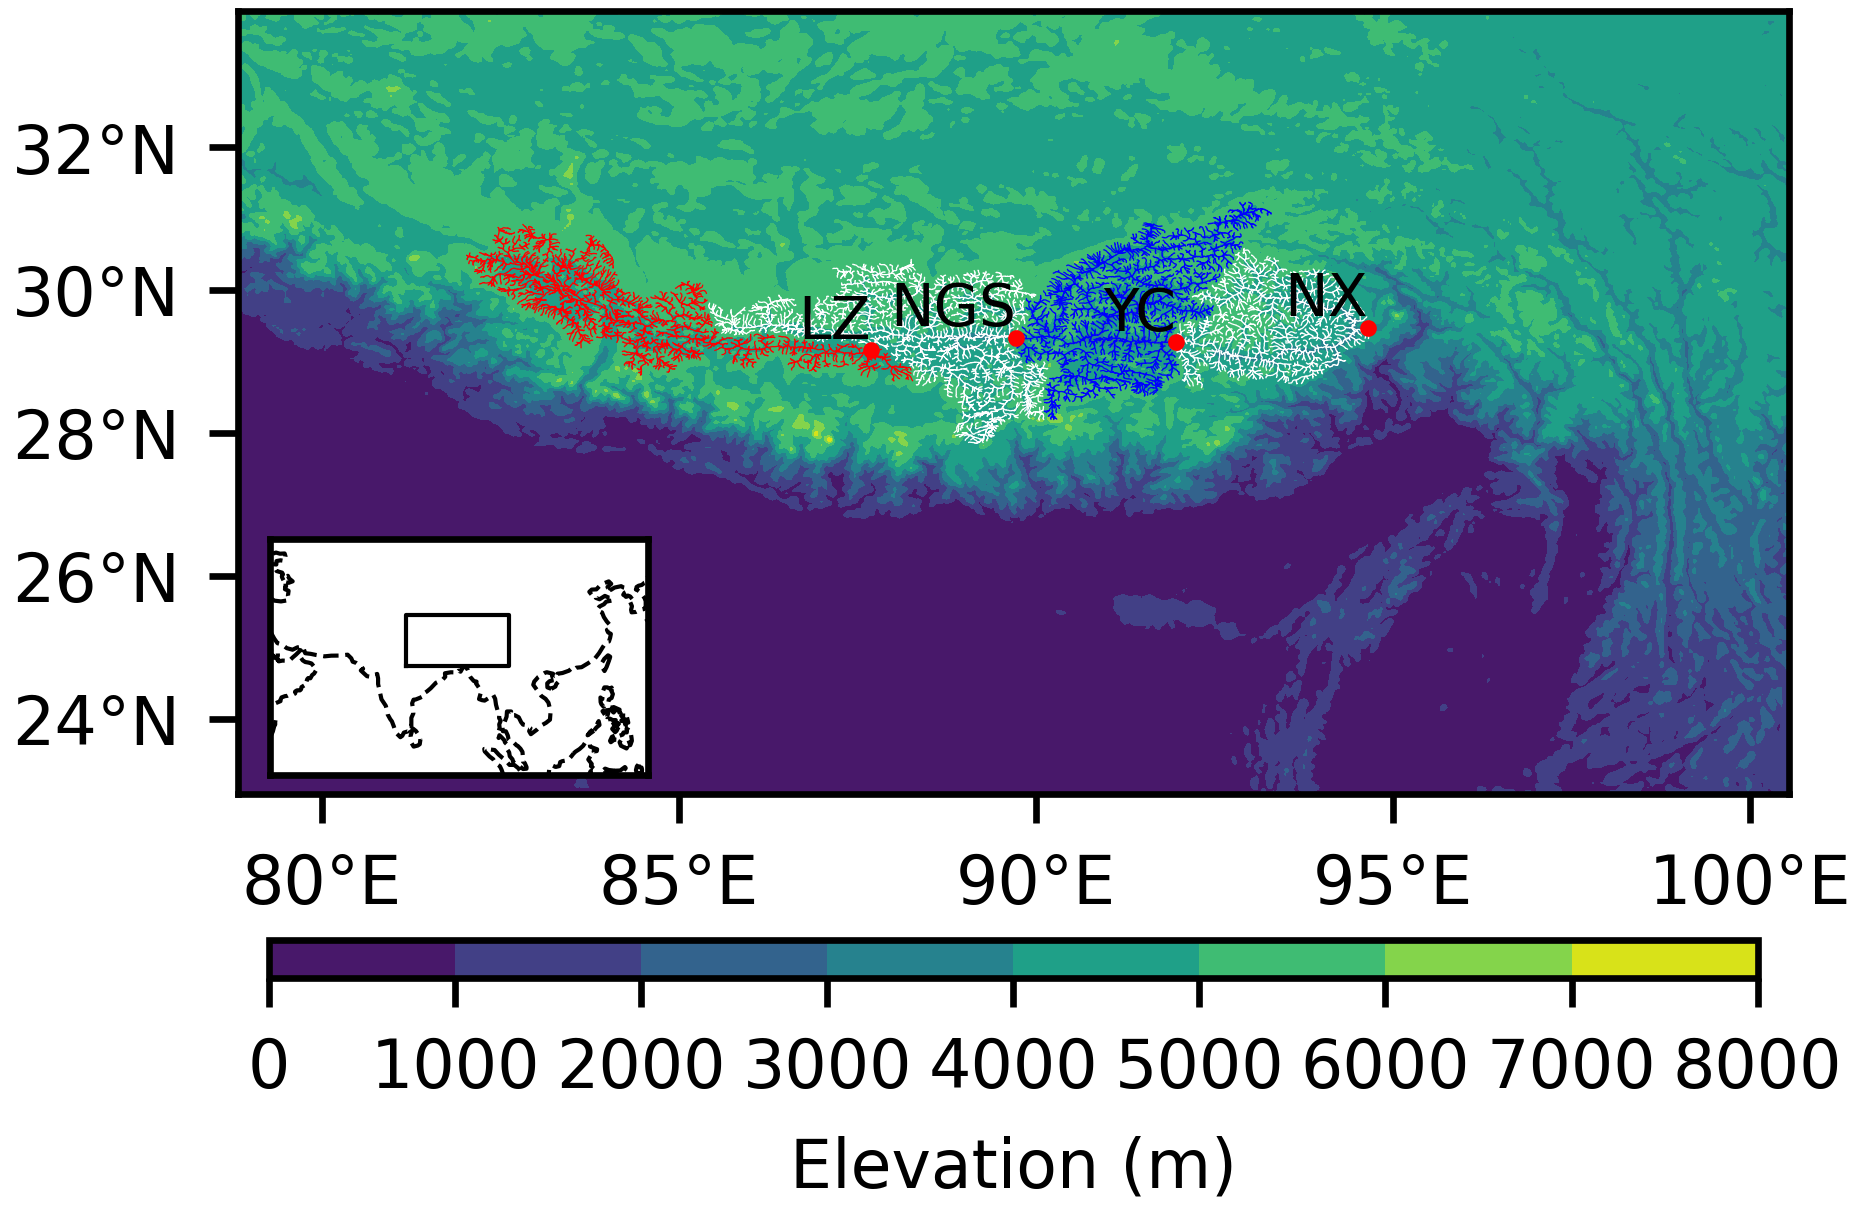

In [27]:
fig = plt.figure(figsize=(8 / 2.54, 6 / 2.54), dpi=FIGDPI, layout="constrained")
ax = fig.add_subplot(111)
cf = ax.contourf(lon, lat, hgt)
for i in range(rivnet.height):
    if rivnet[i, "gauge"] == "Lazi":
        color = "r"
    elif rivnet[i, "gauge"] == "Nagesha":
        color = "y"
    elif rivnet[i, "gauge"] == "Yangcun":
        color = "b"
    else:
        color = "w"
    ax.plot(rivnet[i, "lon"], rivnet[i, "lat"], color=color, linewidth=0.15)
for gaugename, gaugelat, gaugelon in gauge.select(["gauge", "lat", "lon"]).iter_rows():
    gaugeshortname = {"Nuxia": "NX", "Yangcun": "YC", "Nugesha": "NGS", "Lazi": "LZ"}[
        gaugename
    ]
    # gaugeshortname = {"Nuxia": "奴下", "Yangcun": "杨村", "Nugesha":"努各沙", "Lazi":"拉孜"}[gaugename]
    ax.plot(gaugelon, gaugelat, "ro", markersize=1)
    ax.text(gaugelon, gaugelat, gaugeshortname, fontsize=7, ha="right", va="bottom")

cb = plt.colorbar(
    ax=ax, mappable=cf, orientation="horizontal", aspect=40, pad=0.02, shrink=0.96
)
cb.set_label("Elevation (m)", fontsize=8)
ax.set_aspect("equal")
ax.set_xticks([80, 85, 90, 95, 100])
ax.set_xticklabels(["80°E", "85°E", "90°E", "95°E", "100°E"])
ax.set_yticks([24, 26, 28, 30, 32])
ax.set_yticklabels(["24°N", "26°N", "28°N", "30°N", "32°N"])

lat_min, lat_max = lat.min(), lat.max()
lon_min, lon_max = lon.min(), lon.max()

subax = fig.add_axes(
    rect=[0.15, 0.30, 0.20, 0.20],
    frameon=True,
    aspect=1,
)
for clat, clon in coast:
    subax.plot(clon, clat, color="k", linestyle="--", linewidth=0.5)
subax.plot(
    [lon_min, lon_max, lon_max, lon_min, lon_min],
    [lat_min, lat_min, lat_max, lat_max, lat_min],
    color="k",
    linewidth=0.5,
)
subax.set_xlim(50, 130)
subax.set_ylim(0, 50)
subax.set_xticks([])
subax.set_yticks([])

fig.savefig(FIGROOT.joinpath("domain").with_suffix(FIGSUFFIX), bbox_inches="tight")